# Importing

In [43]:
# Importando bibliotecas necessárias
import os
import sys
import builtins 
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import seaborn as sns

import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline


from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.types import StringType, NumericType
from pyspark.sql import Window
from pyspark.sql.functions import col, when, count, isnan, isnull, mean, lit, avg, desc, isnan, percentile_approx, concat_ws, sum as ps_sum, rand, approx_count_distinct, round as ps_round, month, expr
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
from pyspark.ml.feature import (StringIndexer, OneHotEncoder, FeatureHasher, VectorAssembler, StandardScaler)
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import *
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import Imputer
from pyspark.storagelevel import StorageLevel 
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.functions import vector_to_array
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark = SparkSession.builder \
    .appName("Airline Delay Estimatoor") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", 200) \
    .config("spark.driver.memory",   "8g") \
    .config("spark.executor.memory", "8g")\
    .getOrCreate()

# Converter em para parquet

EXECUTE ESSA CÉLULA APENAS A PRIMEIRA VEZ PARA COVERTER O DATASET EM PARQUET!!!!!!!!

In [3]:
csv_path = "datasets/airline.csv.shuffle"

df_csv = spark.read.csv(csv_path, header=True, inferSchema=True)
df_csv.write.mode("overwrite")\
      .partitionBy("Year","Month")\
      .parquet("datasets/parquet/flights")

Número de linhas no DataFrame: 123534969


Após a primeira execução, rode a partir daqui pra baixo

# Lendo Parquet

In [3]:
df_raw = spark.read.parquet("datasets/parquet/flights")

num_linhas = df_raw.count()
print(f"Número de linhas no DataFrame: {num_linhas}")

Número de linhas no DataFrame: 123534969


In [4]:
print('Shape of the dataset: ', (df_raw.count(), len(df_raw.columns)))

Shape of the dataset:  (123534969, 29)


Dados relevantes sobre o dataset: Os dados presentes nele são desde Outubro de 1987 até April de 2008. Possui mais de 120 milhões de linhas de dados coletados. É possível analizar antes e depois do 11/09/2001.



# Data Analysis

| # | Nome da Coluna | Descrição |
|---|----------------|-----------|
| 1 | **Year** | Ano do voo (1987 – 2008) |
| 2 | **Month** | Mês (1 – 12) |
| 3 | **DayofMonth** | Dia do mês (1 – 31) |
| 4 | **DayOfWeek** | Dia da semana (1 = Segunda … 7 = Domingo) |
| 5 | **DepTime** | Hora real de partida (local, hhmm) |
| 6 | **CRSDepTime** | Hora programada de partida (local, hhmm) |
| 7 | **ArrTime** | Hora real de chegada (local, hhmm) |
| 8 | **CRSArrTime** | Hora programada de chegada (local, hhmm) |
| 9 | **UniqueCarrier** | Código único da companhia aérea |
| 10 | **FlightNum** | Número do voo |
| 11 | **TailNum** | Matrícula (tail number) da aeronave |
| 12 | **ActualElapsedTime** | Tempo total real de voo (min) |
| 13 | **CRSElapsedTime** | Tempo total programado (min) |
| 14 | **AirTime** | Tempo em voo (min) |
| 15 | **ArrDelay** | Atraso na chegada (min) |
| 16 | **DepDelay** | Atraso na partida (min) |
| 17 | **Origin** | Aeroporto de origem (código IATA) |
| 18 | **Dest** | Aeroporto de destino (código IATA) |
| 19 | **Distance** | Distância da rota (milhas) |
| 20 | **TaxiIn** | Tempo de táxi após pouso (min) |
| 21 | **TaxiOut** | Tempo de táxi antes da decolagem (min) |
| 22 | **Cancelled** | Voo cancelado? (1 = sim, 0 = não) |
| 23 | **CancellationCode** | Motivo do cancelamento (A = companhia, B = clima, C = NAS, D = segurança) |
| 24 | **Diverted** | Voo alternado? (1 = sim, 0 = não) |
| 25 | **CarrierDelay** | Atraso atribuído à companhia (min) |
| 26 | **WeatherDelay** | Atraso por condições climáticas (min) |
| 27 | **NASDelay** | Atraso por Sistema Nacional de Espaço Aéreo (min) |
| 28 | **SecurityDelay** | Atraso por questões de segurança (min) |
| 29 | **LateAircraftDelay** | Atraso causado por chegada tardia da aeronave (min) |

### Entendendo o básico sobre o dataset

In [5]:
df_raw.printSchema()

root
 |-- ActualElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CarrierDelay: string (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- LateAircraftDelay: string (nullable = true)
 |-- NASDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- SecurityDelay: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- TaxiIn: string (nullabl

In [7]:
df_raw.show(10)

+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+-------+------+-------+-------------+------------+----+-----+
|ActualElapsedTime|AirTime|ArrDelay|ArrTime|CRSArrTime|CRSDepTime|CRSElapsedTime|CancellationCode|Cancelled|CarrierDelay|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Diverted|FlightNum|LateAircraftDelay|NASDelay|Origin|SecurityDelay|TailNum|TaxiIn|TaxiOut|UniqueCarrier|WeatherDelay|Year|Month|
+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+-------+------+-------+-------------+------------+----+-----+
|              147|    103|      15|   1953|      1938|      1700|           158|            N

In [8]:
df_raw.describe()

DataFrame[summary: string, ActualElapsedTime: string, AirTime: string, ArrDelay: string, ArrTime: string, CRSArrTime: string, CRSDepTime: string, CRSElapsedTime: string, CancellationCode: string, Cancelled: string, CarrierDelay: string, DayOfWeek: string, DayofMonth: string, DepDelay: string, DepTime: string, Dest: string, Distance: string, Diverted: string, FlightNum: string, LateAircraftDelay: string, NASDelay: string, Origin: string, SecurityDelay: string, TailNum: string, TaxiIn: string, TaxiOut: string, UniqueCarrier: string, WeatherDelay: string, Year: string, Month: string]

## Tratamento de valores nulos e cast

Os valores nulos ainda não estão tratados, como o cast ainda não foi feito, não sabemos quais dados são realmente nulos como NA, NaN e Null.

### Utils

In [4]:
def show_null(df_raw, opt = 1, chuncks = 10):
    try:
        spark.range(1).count()
    except Exception as e:
        print("Spark morto:", e)

    string_columns = [f.name for f in df_raw.schema.fields if isinstance(f.dataType, StringType)]
    num_cols   = [f.name for f in df_raw.schema if isinstance(f.dataType, NumericType)]
    null_labels = ["NULL", "NA", "None", ""]
    exprs = []
    
    for c in df_raw.columns:
        base = col(c).isNull()
        if c in num_cols:
            base = base | isnan(col(c))
        if opt == 1 and c in string_columns:
            base = base | col(c).isin(null_labels)
        exprs.append(ps_sum(base.cast("int")).alias(c))

    null_df = df_raw.agg(*exprs)      
    null_counts = null_df.first().asDict()

    total = df_raw.count()
    perc = {k: builtins.round(v/total*100,2) for k, v in null_counts.items()}
    ordenado = sorted(perc.items(), key=lambda x: x[1], reverse=True)

    null_df.show()
    # Visualização da porcentagem
    for i in range(0, len(ordenado), chuncks):
        for colname, p in ordenado[i:i+chuncks]:
            print(f"{colname:25}: {p}%  ({null_counts[colname]})")
        print('-'*40)

### Realizando o casting e reprensentando os dados nulos (ex.: NA, '', NULL e None) como o objeto especial None, indicando a ausência de valor

In [5]:
# Separando as colunas numéricas para tratamento
columns_to_int = ["ActualElapsedTime", "AirTime", "ArrDelay", "CRSElapsedTime", "DepDelay",
    "Distance", "TaxiIn", "TaxiOut", "CarrierDelay", "WeatherDelay",
    "NASDelay", "SecurityDelay", "LateAircraftDelay", "DepTime", "ArrTime"
]

# Tratando colunas, convertendo elas para dado numérico
# Neste caso Int
for column in columns_to_int:
    df_raw = df_raw.withColumn(
        column,
        when(col(column).isin('', 'NA', 'NULL', 'None'), None)
        .otherwise(col(column).cast(IntegerType()))
    )

# Facilitando a compreensão de voos com delay
df_raw = df_raw.withColumn("IsArrDelay", when(col("ArrDelay") > 0, 1).otherwise(0))
df_raw = df_raw.withColumn("IsDepDelay", when(col("DepDelay") > 0, 1).otherwise(0))
df_raw.show(10)

+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+-------+------+-------+-------------+------------+----+-----+----------+----------+
|ActualElapsedTime|AirTime|ArrDelay|ArrTime|CRSArrTime|CRSDepTime|CRSElapsedTime|CancellationCode|Cancelled|CarrierDelay|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Diverted|FlightNum|LateAircraftDelay|NASDelay|Origin|SecurityDelay|TailNum|TaxiIn|TaxiOut|UniqueCarrier|WeatherDelay|Year|Month|IsArrDelay|IsDepDelay|
+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+-------+------+-------+-------------+------------+----+-----+----------+----------+
|              147|    103| 

In [7]:
df_raw.printSchema()

root
 |-- ActualElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CarrierDelay: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- LateAircraftDelay: integer (nullable = true)
 |-- NASDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- SecurityDelay: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- TaxiIn: int

### Nulos antes do tratamento

In [8]:
show_null(df_raw)

+-----------------+--------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+--------+--------+--------+-------------+------------+----+-----+----------+----------+
|ActualElapsedTime| AirTime|ArrDelay|ArrTime|CRSArrTime|CRSDepTime|CRSElapsedTime|CancellationCode|Cancelled|CarrierDelay|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Diverted|FlightNum|LateAircraftDelay|NASDelay|Origin|SecurityDelay| TailNum|  TaxiIn| TaxiOut|UniqueCarrier|WeatherDelay|Year|Month|IsArrDelay|IsDepDelay|
+-----------------+--------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+--------+--------+--------+-------------+------------+----+-----+----------+----------+
|          25

### Tratamento de dados nulos em colunas categóricas
| # | Nome da Coluna | Descrição |
|---|----------------|-----------|
| 9 | **UniqueCarrier** | Código único da companhia aérea |
| 11 | **TailNum** | Matrícula (tail number) da aeronave |
| 17 | **Origin** | Aeroporto de origem (código IATA) |
| 18 | **Dest** | Aeroporto de destino (código IATA) |
| 23 | **CancellationCode** | Motivo do cancelamento (A = companhia, B = clima, C = NAS, D = segurança) |

In [6]:
string_columns = [f.name for f in df_raw.schema.fields if isinstance(f.dataType, StringType)]
null_labels = ["NULL", "NA", "None", ""]

print(string_columns)

# Normalizando nulos em colunas categóricas
for c in string_columns:
    df_raw = df_raw.withColumn(
        c,
        when(col(c).isin(null_labels), None).otherwise(col(c))
    )


['CancellationCode', 'Dest', 'Origin', 'TailNum', 'UniqueCarrier']


### Tratando dados ausentes em colunas sinalizadoras

| # | Nome da Coluna | Descrição |
|---|----------------|-----------|
| 11 | **TailNum** | Matrícula (tail number) da aeronave |
 14 | **AirTime** | Tempo em voo (min) |
| 12 | **ActualElapsedTime** | Tempo total real de voo (min) |
| 20 | **TaxiIn** | Tempo de táxi após pouso (min) |
| 21 | **TaxiOut** | Tempo de táxi antes da decolagem (min) |
| 25 | **CarrierDelay** | Atraso atribuído à companhia (min) |
| 26 | **WeatherDelay** | Atraso por condições climáticas (min) |
| 27 | **NASDelay** | Atraso por Sistema Nacional de Espaço Aéreo (min) |
| 28 | **SecurityDelay** | Atraso por questões de segurança (min) |
| 29 | **LateAircraftDelay** | Atraso causado por chegada tardia da aeronave (min) |

In [7]:
cols_flag = ["CarrierDelay","WeatherDelay","NASDelay",
             "SecurityDelay","LateAircraftDelay","TaxiIn",
             "TaxiOut","AirTime","ActualElapsedTime","TailNum"]

for c in cols_flag:
    df_raw = df_raw.withColumn(f"{c}_missing", when(col(c).isNull(), 1).otherwise(0))

### Tratamento de dados nulos no dataset

In [8]:
# Tirando valores nulos de possíveis causas de delay e inserindo 0
delay_causes = ["CarrierDelay",
                "WeatherDelay",
                "NASDelay",
                "SecurityDelay",
                "LateAircraftDelay", 
                "ArrDelay", 
                "DepDelay", 
                "ArrTime", 
                "DepTime",
                "AirTime", 
                "ActualElapsedTime", 
                "CRSElapsedTime"]

df_raw = df_raw.fillna({c: 0 for c in delay_causes})

# Comportamento de encerrar o taxiamento 
# caso o voo seja cancelado ou desviado
for taxi, airport_col in [("TaxiOut", "Origin"), ("TaxiIn", "Dest")]:
    df_raw = df_raw.withColumn(
        taxi,
        when((col("Cancelled") == 1) | (col("Diverted") == 1), 0).otherwise(col(taxi))
    )

    # Inserir a mediana existente da taxa de taxi por aeroporto nos dados nulos
    w = Window.partitionBy(airport_col)
    df_raw =  df_raw.withColumn(
        taxi,
        when(col(taxi).isNull(),
             percentile_approx(col(taxi), 0.5).over(w)
        ).otherwise(col(taxi))
    )


# Tempo estipulado em dados estátisticos de voos
median_speed = 825 # velocidade média de cruzeiro Boeing 737, avião mais utilizado nos EUA

df_raw = df_raw.withColumn(
    "AirTime",
    when(col("AirTime").isNull() & (col("Cancelled") == 0) & (col("Diverted") == 0),
        (col("Distance") / median_speed * 60).cast("int")
        ).otherwise(col("AirTime"))
)

# Tempo de chegada estimada (ActualElapsedTime), caso sela nula, inserir o tempo total programado (CRSElapsedTime) se tiver
df_raw = df_raw.withColumn(
    "ActualElapsedTime",
    when(col("ActualElapsedTime").isNull(), col("CRSElapsedTime"))
    .otherwise(col("ActualElapsedTime"))
)

# Tratando Horários
df_raw = df_raw.filter(
    ~((col("DepTime").isNull() | col("ArrTime").isNull()) & (col("Cancelled") == 0))
)

# Preparando colunas categóricas para a fase de ONE HOT En.
df_raw = df_raw.fillna({
    "CancellationCode": "unknown",
    "TailNum": "UNKN",
    "Origin": "unknown",
    "Dest": "unknown",
    "UniqueCarrier": "unknown",
})

# Tratando dados faltantes ou nulos na coluna de distancia
w_route = Window.partitionBy("Origin", "Dest")
df_raw = df_raw.withColumn(
    "Distance",
    when(col("Distance").isNull(),
        percentile_approx(col("Distance"), 0.5).over(w_route)
        ).otherwise(col("Distance"))
)

df_raw = df_raw.fillna({"Distance": 0})

df_raw = df_raw.withColumn("Route", concat_ws("-", "Origin", "Dest"))

df_raw = df_raw.persist(StorageLevel.MEMORY_AND_DISK)
df_raw.count()

123534969

### Nulos após o tratamento

In [12]:
show_null(df_raw, 2)

+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+--------+------+-------------+-------+------+-------+-------------+------------+----+-----+----------+----------+--------------------+--------------------+----------------+---------------------+-------------------------+--------------+---------------+---------------+-------------------------+---------------+-----+
|ActualElapsedTime|AirTime|ArrDelay|ArrTime|CRSArrTime|CRSDepTime|CRSElapsedTime|CancellationCode|Cancelled|CarrierDelay|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Diverted|FlightNum|LateAircraftDelay|NASDelay|Origin|SecurityDelay|TailNum|TaxiIn|TaxiOut|UniqueCarrier|WeatherDelay|Year|Month|IsArrDelay|IsDepDelay|CarrierDelay_missing|WeatherDelay_missing|NASDelay_missing|SecurityDelay_missing|LateAircraftDelay_missing|TaxiIn_missing|TaxiOut_missing|AirTime_missi

In [24]:
p = 0.10 # Separando 10 % de cada companhia para análise
seed = 42

base = (
    df_raw.withColumn("rand", functions.rand(seed))
    .where(functions.col("rand") < p)
    .drop("rand")
)

## EDA

In [18]:
print("Amostra          :", sample_carrier.count())
print("Dataset completo :", df_raw.count())

Amostra          : 12355764
Dataset completo : 123534969


In [19]:
# contagem por companhia
(sample_carrier.groupBy("UniqueCarrier")
               .count()
               .orderBy("count", ascending=False)
               .show())

# atraso médio e desvio-padrão por companhia
(sample_carrier.groupBy("UniqueCarrier")
               .agg(ps_round(avg("ArrDelay"),2).alias("avg_arr"),
                    ps_round(avg("DepDelay"),2).alias("avg_dep"))
               .orderBy("avg_arr", ascending=False)
               .show())

+-------------+-------+
|UniqueCarrier|  count|
+-------------+-------+
|           DL|1655348|
|           WN|1597706|
|           AA|1498652|
|           US|1406266|
|           UA|1330572|
|           NW|1030450|
|           CO| 814620|
|           MQ| 395772|
|           TW| 375037|
|           HP| 364316|
|           OO| 308816|
|           AS| 289152|
|           XE| 234695|
|           EV| 169326|
|           OH| 146463|
|           FL| 126578|
|           EA|  92569|
|           PI|  87224|
|           YV|  85226|
|           B6|  81195|
+-------------+-------+
only showing top 20 rows

+-------------+-------+-------+
|UniqueCarrier|avg_arr|avg_dep|
+-------------+-------+-------+
|           YV|  10.76|  12.23|
|           EV|  10.47|  13.14|
|           PI|  10.24|   9.36|
|           B6|   9.61|  11.14|
|           PS|   9.39|   8.84|
|           FL|   9.28|  10.05|
|           XE|   8.88|   8.31|
|           UA|   8.32|   9.44|
|           AS|   8.27|   8.19|
|           MQ

(array([  508.,   469.,   724.,  1029.,  1428.,  1910.,  2596.,  3548.,
         4369.,  5829., 10331.,  8361.,  8144.,  7959., 11002.,  6728.,
         5927.,  4893.,  4156.,  3675.,  4514.,  2293.,  2038.,  1804.,
         1539.,  1302.,  1162.,  1026.,   928.,   778.,  1058.,   629.,
          559.,   531.,   474.,   438.,   421.,   366.,   375.,   368.,
          470.,   258.,   287.,   258.,   233.,   223.,   207.,   207.,
          170.,   183.,   254.,   158.,   149.,   150.,   149.,   123.,
          112.,   111.,   114.,    99.,   138.,    85.,   103.,    72.,
          100.,    76.,    66.,    76.,    62.,    65.,    79.,    64.,
           54.,    64.,    49.,    54.,    44.,    40.,    56.,    44.,
           68.,    33.,    42.,    30.,    32.,    34.,    31.,    20.,
           32.,    28.,    37.,    29.,    28.,    30.,    19.,    21.,
           20.,    21.,    20.,    37.]),
 array([-30. , -27.9, -25.8, -23.7, -21.6, -19.5, -17.4, -15.3, -13.2,
        -11.1,  -9. ,  

Text(0.5, 1.0, 'Distribuição ArrDelay (amostra 0,1 % do dataset completo)')

Text(0.5, 0, 'Minutos de atraso')

Text(0, 0.5, 'Frequência')

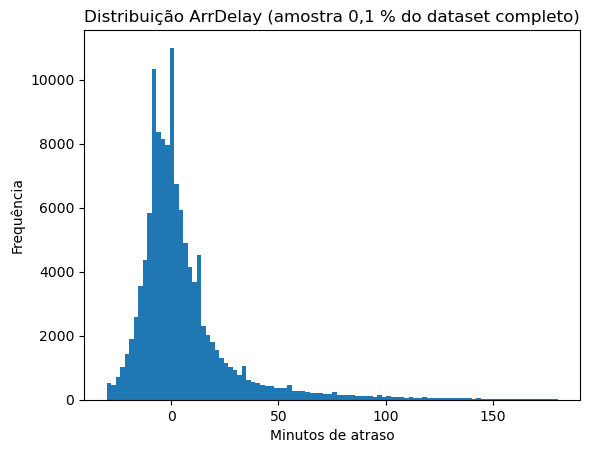

In [20]:
pdf = (sample_carrier
       .select("ArrDelay")
       .sample(fraction=0.01, seed=1)    # 1 % da amostra = ~120k linhas
       .toPandas())

plt.hist(pdf["ArrDelay"], bins=100, range=(-30, 180))
plt.title("Distribuição ArrDelay (amostra 0,1 % do dataset completo)")
plt.xlabel("Minutos de atraso")
plt.ylabel("Frequência")
plt.show()

### Boxplot de atraso por companhia

<Figure size 1200x600 with 0 Axes>

<Axes: title={'center': 'ArrDelay'}, xlabel='UniqueCarrier'>

Text(0.5, 0.98, '')

Text(0.5, 1.0, 'ArrDelay por companhia (amostra)')

Text(0, 0.5, 'Minutos')

<Figure size 1200x600 with 0 Axes>

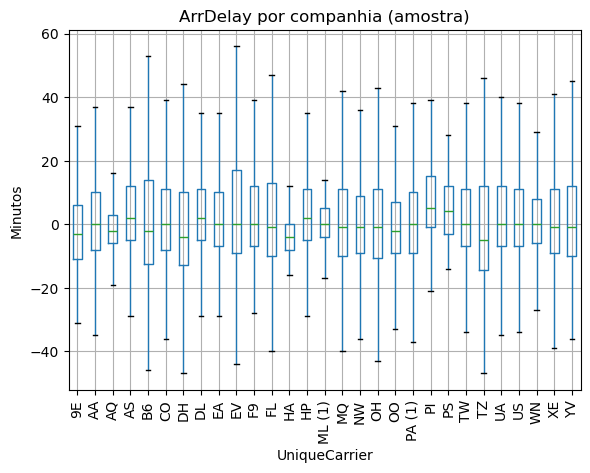

In [21]:
pdf2 = (sample_carrier
        .select("UniqueCarrier", "ArrDelay")
        .sample(fraction=0.01, seed=2)    # reduz ainda mais
        .toPandas())

plt.figure(figsize=(12,6))
pdf2.boxplot(column="ArrDelay", by="UniqueCarrier", rot=90, showfliers=False)
plt.suptitle("")
plt.title("ArrDelay por companhia (amostra)")
plt.ylabel("Minutos")
plt.show()

### Atraso médio ao longo do ano

+-----+-------------+--------+
|Month|UniqueCarrier|mean_arr|
+-----+-------------+--------+
|1    |9E           |10.06   |
|1    |AA           |7.46    |
|1    |AQ           |-0.38   |
|1    |AS           |8.82    |
|1    |B6           |9.16    |
|1    |CO           |7.86    |
|1    |DH           |11.74   |
|1    |DL           |9.02    |
|1    |EA           |11.66   |
|1    |EV           |7.31    |
|1    |F9           |6.81    |
|1    |FL           |8.94    |
|1    |HA           |-1.36   |
|1    |HP           |9.06    |
|1    |ML (1)       |12.29   |
|1    |MQ           |9.53    |
|1    |NW           |6.78    |
|1    |OH           |8.13    |
|1    |OO           |11.05   |
|1    |PA (1)       |6.51    |
|1    |PI           |12.01   |
|1    |PS           |6.95    |
|1    |TW           |11.19   |
|1    |TZ           |10.64   |
|1    |UA           |10.03   |
|1    |US           |6.88    |
|1    |WN           |5.88    |
|1    |XE           |8.03    |
|1    |YV           |10.96   |
|2    |9

<Figure size 1700x600 with 0 Axes>

<Axes: ylabel='Month'>

Text(0.5, 1.0, 'Atraso médio (min) por Mês e Companhia — amostra 10 %')

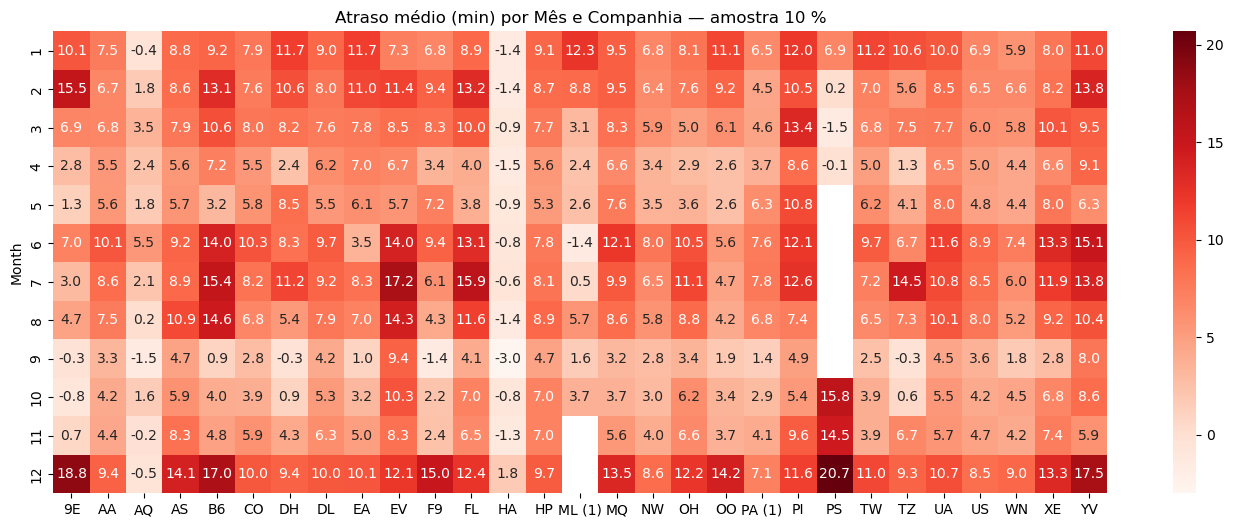

In [46]:
(sample_carrier
   .groupBy("Month", "UniqueCarrier")
   .agg(ps_round(avg("ArrDelay"), 2).alias("mean_arr"))
   .orderBy("Month", "UniqueCarrier")
   .show(60, truncate=False))

pivot_df = (sample_carrier
            .groupBy("Month")
            .pivot("UniqueCarrier")           # cria coluna para cada empresa
            .agg(ps_round(avg("ArrDelay"), 1))   # média de atraso
            .orderBy("Month"))

pivot_df.show(truncate=False)

pdf = pivot_df.toPandas().set_index("Month").sort_index()
plt.figure(figsize=(17,6))
sns.heatmap(pdf, annot=True, fmt=".1f", cmap="Reds")
plt.title("Atraso médio (min) por Mês e Companhia — amostra 10 %")
plt.show()

### Heatmap Origin × Dest com maior atraso

+------+----+------------------+-------+
|Origin|Dest|mean_arr          |flights|
+------+----+------------------+-------+
|EWR   |LIT |33.9940119760479  |167    |
|BGR   |EWR |33.82520325203252 |246    |
|MSN   |EWR |31.42452830188679 |212    |
|EWR   |BQN |30.921397379912662|229    |
|JAC   |ORD |30.881720430107528|279    |
|GUC   |DFW |30.228571428571428|245    |
|ACY   |ATL |29.740384615384617|104    |
|CEC   |SFO |29.091525423728815|295    |
|LEX   |EWR |28.633333333333333|180    |
|ORD   |MQT |27.6981981981982  |222    |
|SDF   |EWR |27.374816983894583|683    |
|HDN   |ORD |26.51101321585903 |227    |
|ATL   |BGR |26.38317757009346 |107    |
|GRR   |EWR |25.68059701492537 |335    |
|ATL   |HHH |25.475728155339805|206    |
|IAD   |BHM |25.31654676258993 |139    |
|GRB   |MQT |24.857142857142858|154    |
|DAL   |LGA |24.623762376237625|101    |
|EWR   |LEX |24.573529411764707|204    |
|PNS   |ORD |23.94326241134752 |141    |
+------+----+------------------+-------+



<Axes: xlabel='Dest', ylabel='Origin'>

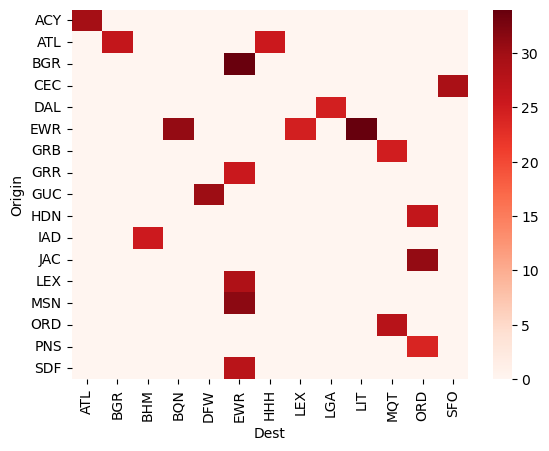

In [23]:
top_routes = (sample_carrier
              .groupBy("Origin", "Dest")
              .agg(avg("ArrDelay").alias("mean_arr"), count("*").alias("flights"))
              .filter("flights > 100")           # ignora rotas raras
              .orderBy("mean_arr", ascending=False)
              .limit(20))

top_routes.show(truncate=False)

pdf_heat = (top_routes.select("Origin","Dest","mean_arr").toPandas()
            .pivot(index="Origin", columns="Dest", values="mean_arr")
            .fillna(0))

sns.heatmap(pdf_heat, cmap="Reds")


### Cancelamentos e desvio

In [24]:
(stats_cancel := sample_carrier
    .select(expr("100*avg(Cancelled)  as pct_cancelados"),
            expr("100*avg(Diverted)   as pct_desrtidos"))).show()

(sample_carrier.groupBy("UniqueCarrier")
               .agg(ps_round(100*avg("Cancelled"),2).alias("%_cancel"),
                    ps_round(100*avg("Diverted"),2).alias("%_divert"))
               .orderBy("%_cancel", ascending=False)
               .show())

+-----------------+------------------+
|   pct_cancelados|     pct_desrtidos|
+-----------------+------------------+
|1.865202346046752|0.2297632101098726|
+-----------------+------------------+

+-------------+--------+--------+
|UniqueCarrier|%_cancel|%_divert|
+-------------+--------+--------+
|           MQ|    3.97|     0.2|
|           YV|    3.41|    0.19|
|           OH|    3.24|    0.18|
|           EA|    3.18|    0.76|
|           DH|    3.18|    0.17|
|           9E|    3.04|     0.3|
|           EV|    2.86|    0.19|
|           XE|    2.19|    0.33|
|           UA|    2.18|    0.23|
|           OO|    2.12|    0.16|
|           NW|     2.1|    0.25|
|           US|    2.08|    0.22|
|           AS|    1.97|    0.38|
|           AA|    1.92|    0.28|
|           TW|    1.83|    0.29|
|           AQ|    1.82|     0.0|
|       ML (1)|    1.72|    0.13|
|           DL|    1.55|    0.17|
|           HP|     1.5|    0.15|
|           PS|    1.38|    0.22|
+-------------+-------

<Figure size 1200x1000 with 0 Axes>

([<matplotlib.axis.XTick at 0x7fdf079d4d10>,
 [Text(0, 0, 'ActualElapsedTime'),
  Text(1, 0, 'AirTime'),
  Text(2, 0, 'ArrDelay'),
  Text(3, 0, 'ArrTime'),
  Text(4, 0, 'CRSArrTime'),
  Text(5, 0, 'CRSDepTime'),
  Text(6, 0, 'CRSElapsedTime'),
  Text(7, 0, 'Cancelled'),
  Text(8, 0, 'CarrierDelay'),
  Text(9, 0, 'DayOfWeek'),
  Text(10, 0, 'DayofMonth'),
  Text(11, 0, 'DepDelay'),
  Text(12, 0, 'DepTime'),
  Text(13, 0, 'Distance'),
  Text(14, 0, 'Diverted'),
  Text(15, 0, 'FlightNum'),
  Text(16, 0, 'LateAircraftDelay'),
  Text(17, 0, 'NASDelay'),
  Text(18, 0, 'SecurityDelay'),
  Text(19, 0, 'TaxiIn'),
  Text(20, 0, 'TaxiOut'),
  Text(21, 0, 'WeatherDelay'),
  Text(22, 0, 'Year'),
  Text(23, 0, 'Month'),
  Text(24, 0, 'IsArrDelay'),
  Text(25, 0, 'IsDepDelay'),
  Text(26, 0, 'CarrierDelay_missing'),
  Text(27, 0, 'WeatherDelay_missing'),
  Text(28, 0, 'NASDelay_missing'),
  Text(29, 0, 'SecurityDelay_missing'),
  Text(30, 0, 'LateAircraftDelay_missing'),
  Text(31, 0, 'TaxiIn_missing

([<matplotlib.axis.YTick at 0x7fdf07820750>,
 [Text(0, 0, 'ActualElapsedTime'),
  Text(0, 1, 'AirTime'),
  Text(0, 2, 'ArrDelay'),
  Text(0, 3, 'ArrTime'),
  Text(0, 4, 'CRSArrTime'),
  Text(0, 5, 'CRSDepTime'),
  Text(0, 6, 'CRSElapsedTime'),
  Text(0, 7, 'Cancelled'),
  Text(0, 8, 'CarrierDelay'),
  Text(0, 9, 'DayOfWeek'),
  Text(0, 10, 'DayofMonth'),
  Text(0, 11, 'DepDelay'),
  Text(0, 12, 'DepTime'),
  Text(0, 13, 'Distance'),
  Text(0, 14, 'Diverted'),
  Text(0, 15, 'FlightNum'),
  Text(0, 16, 'LateAircraftDelay'),
  Text(0, 17, 'NASDelay'),
  Text(0, 18, 'SecurityDelay'),
  Text(0, 19, 'TaxiIn'),
  Text(0, 20, 'TaxiOut'),
  Text(0, 21, 'WeatherDelay'),
  Text(0, 22, 'Year'),
  Text(0, 23, 'Month'),
  Text(0, 24, 'IsArrDelay'),
  Text(0, 25, 'IsDepDelay'),
  Text(0, 26, 'CarrierDelay_missing'),
  Text(0, 27, 'WeatherDelay_missing'),
  Text(0, 28, 'NASDelay_missing'),
  Text(0, 29, 'SecurityDelay_missing'),
  Text(0, 30, 'LateAircraftDelay_missing'),
  Text(0, 31, 'TaxiIn_missing

Text(0.5, 1.0, 'Correlation heat‑map – Spark ML (no pandas)')

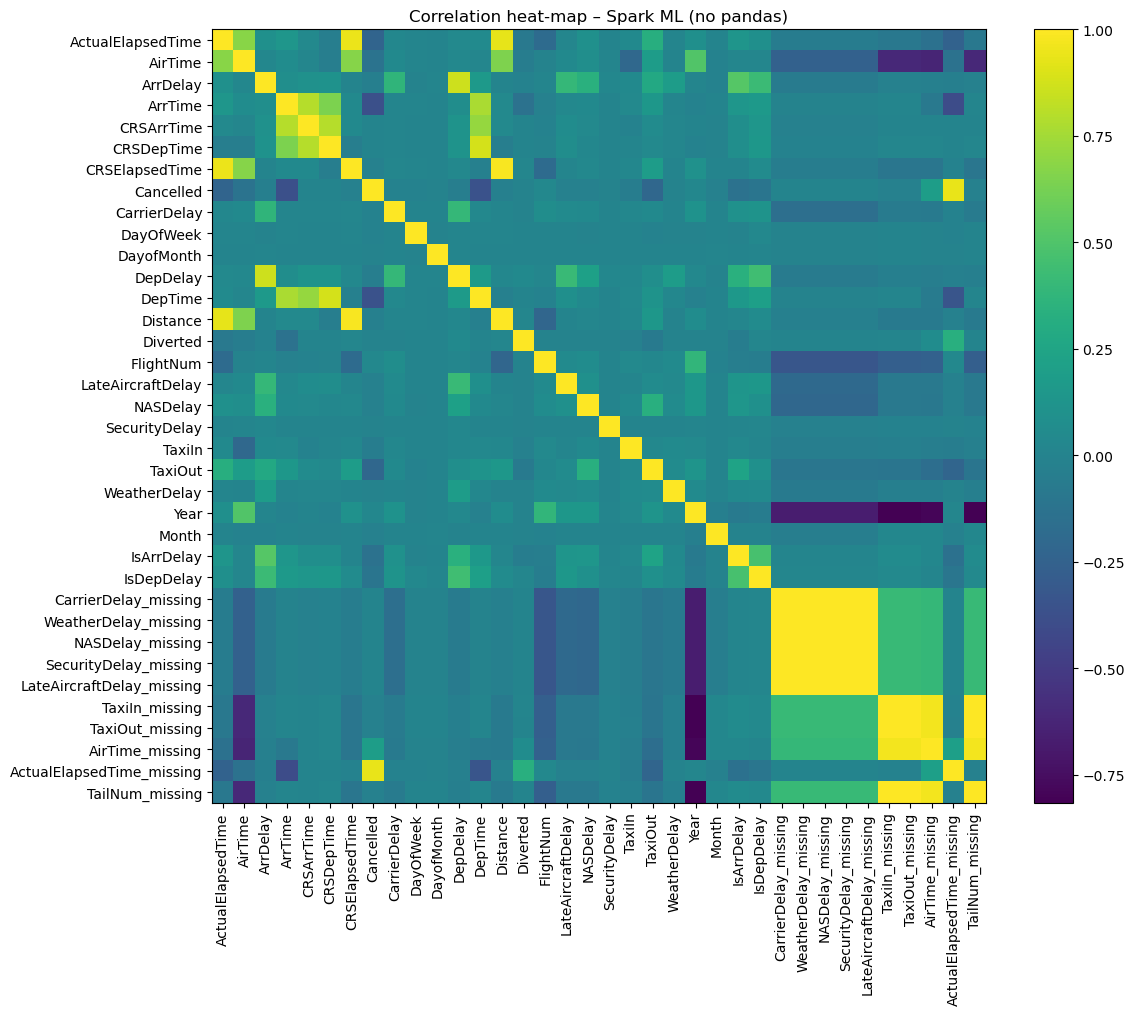

In [25]:
# colunas numéricas
numeric_cols = [f.name for f in sample_carrier.schema.fields
                if isinstance(f.dataType, NumericType)]

# remover linhas com nulos nessas colunas
numeric_df = sample_carrier.select(numeric_cols).na.drop()

# criar coluna vetorial
vec_assembler = VectorAssembler(inputCols=numeric_cols,
                                outputCol="vec",
                                handleInvalid="skip")
vec_df = vec_assembler.transform(numeric_df).select("vec")

# matriz de correlação distribuída (pearson)
corr_matrix = (Correlation.corr(vec_df, "vec", "pearson")
                          .head()[0]          
                          .toArray())        

# plot heat‑map
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, interpolation="nearest") 
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation heat‑map – Spark ML (no pandas)")
plt.tight_layout()
plt.show()


## Entendendo os padrões

In [26]:
# Encontrando o delay médio por dia

delay = sample_carrier.filter(col("ArrDelay") > 0)

mean_delay_per_day = delay.groupBy("DayOfWeek") \
    .agg(avg("ArrDelay").alias("AvgDelay")) \
    .orderBy(desc("AvgDelay"))

df_days = mean_delay_per_day.withColumn(
    "WeekdayName",
    when(col("DayOfWeek") == 1, "Domingo")
    .when(col("DayOfWeek") == 2, "Segunda")
    .when(col("DayOfWeek") == 3, "Terça")
    .when(col("DayOfWeek") == 4, "Quarta")
    .when(col("DayOfWeek") == 5, "Quinta")
    .when(col("DayOfWeek") == 6, "Sexta")
    .when(col("DayOfWeek") == 7, "Sábado")
)

df_days.orderBy(desc("AvgDelay")).show()

+---------+------------------+-----------+
|DayOfWeek|          AvgDelay|WeekdayName|
+---------+------------------+-----------+
|        5| 25.67302882433778|     Quinta|
|        4|25.042136115665787|     Quarta|
|        7|24.027142961006227|     Sábado|
|        1|23.729744582601793|    Domingo|
|        3|23.578315783052247|      Terça|
|        2| 22.76083358623681|    Segunda|
|        6|22.025243754839387|      Sexta|
+---------+------------------+-----------+



+-----+------------------+------------------+
|Month|num_voos_atrasados|      media_atraso|
+-----+------------------+------------------+
|   12|            552753|10.174604284990433|
|    6|            511740| 9.528965617650133|
|    7|            508370| 8.628406670928355|
|    8|            505984| 7.639043204083931|
|    3|            496180| 7.036617184761182|
|    1|            495977| 8.148154561718744|
|   10|            482481|4.6472513582065815|
|   11|            465506| 5.218904770860761|
|    5|            461140| 5.450456664515798|
|    2|            455280| 7.676270931557566|
|    4|            451851| 5.265250628444287|
|    9|            399629| 3.322804605395677|
+-----+------------------+------------------+



<BarContainer object of 12 artists>

Text(0.5, 0, 'Mês')

Text(0, 0.5, 'Voos com atraso (ArrDelay > 0)')

Text(0.5, 1.0, 'Volume de atrasos por mês – amostra 10 %')

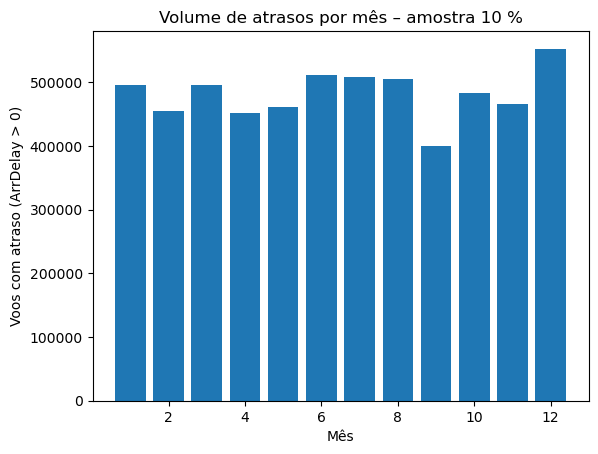

In [27]:
# total de voos atrasados por mês
atrasados = (sample_carrier
             .filter(col("ArrDelay") > 0)
             .groupBy("Month")
             .agg(count("*").alias("num_voos_atrasados")))

# atraso médio por mês
media = (sample_carrier
         .groupBy("Month")
         .agg(avg("ArrDelay").alias("media_atraso")))

# juntar e ordenar
resultado = (atrasados
             .join(media, "Month")
             .orderBy(col("num_voos_atrasados").desc())) 

resultado.show()

pdf = (resultado
       .toPandas()
       .sort_values("Month"))

plt.bar(pdf["Month"], pdf["num_voos_atrasados"])
plt.xlabel("Mês")
plt.ylabel("Voos com atraso (ArrDelay > 0)")
plt.title("Volume de atrasos por mês – amostra 10 %")
plt.show()

In [28]:
# Aeroportos de origem e destino com mais atrasos
min_voos = 300     # quantidade minima de voos

top10_origem = (
    sample_carrier      
    .filter(col("DepDelay") > 0)
    .groupBy("Origin")
    .agg(count("*").alias("num_atrasos"),
         ps_round(avg("DepDelay"), 1).alias("avg_dep_delay"))
    .filter(col("num_atrasos") >= min_voos)
    .orderBy(col("avg_dep_delay").desc())
    .limit(10)
)

top10_origem.show(truncate=False)

top10_dest = (
    sample_carrier      
    .filter(col("DepDelay") > 0)
    .groupBy("Dest")
    .agg(count("*").alias("num_atrasos"),
         ps_round(avg("DepDelay"), 1).alias("avg_dep_delay"))
    .filter(col("num_atrasos") >= min_voos)
    .orderBy(col("avg_dep_delay").desc())
    .limit(10)
)

top10_dest.show(truncate=False)

+------+-----------+-------------+
|Origin|num_atrasos|avg_dep_delay|
+------+-----------+-------------+
|EGE   |797        |46.0         |
|WRG   |483        |43.8         |
|HDN   |596        |42.6         |
|ATW   |666        |42.4         |
|ASE   |497        |42.1         |
|AEX   |437        |42.0         |
|BMI   |683        |41.9         |
|YAK   |458        |41.8         |
|XNA   |2697       |41.1         |
|SGF   |2203       |40.7         |
+------+-----------+-------------+

+----+-----------+-------------+
|Dest|num_atrasos|avg_dep_delay|
+----+-----------+-------------+
|PSG |600        |43.6         |
|YAK |551        |40.6         |
|CWA |339        |40.1         |
|GUM |351        |39.7         |
|CDV |561        |39.4         |
|SCC |345        |38.4         |
|BMI |1044       |37.4         |
|DHN |440        |36.7         |
|ATW |886        |36.2         |
|GTR |321        |36.2         |
+----+-----------+-------------+



In [29]:
min_voos = 300        # só TailNum com >= 300 voos (ajuste conforme tamanho do dado)

# número de voos atrasados por TailNum
top_freq = (
    df_raw.filter(col("ArrDelay") > 0)
          .groupBy("TailNum")
          .agg(count("*").alias("num_atrasos"))
          .filter(col("num_atrasos") >= min_voos)
          .orderBy(col("num_atrasos").desc())
          .limit(10)
)

print("TailNum por quantidade de atrasos")
top_freq.show(truncate=False)

# soma total de minutos de atraso
top_sum = (
    df_raw.filter(col("ArrDelay") > 0)
          .groupBy("TailNum")
          .agg(ps_sum("ArrDelay").alias("soma_min_atraso"))
          .filter(col("soma_min_atraso") > 0)
          .orderBy(col("soma_min_atraso").desc())
          .limit(10)
)

print("TailNum por soma total (minutos) de atraso")
top_sum.show(truncate=False)

# atraso médio (min) – útil para ver 'pior' desempenho
top_avg = (
    df_raw.groupBy("TailNum")
          .agg(ps_round(avg("ArrDelay"),1).alias("media_atraso"),
               count("*").alias("num_voos"))
          .filter(col("num_voos") >= min_voos)
          .orderBy(col("media_atraso").desc())
          .limit(10)
)

print("TailNum por atraso médio")
top_avg.show(truncate=False)

TailNum por quantidade de atrasos
+-------+-----------+
|TailNum|num_atrasos|
+-------+-----------+
|UNKN   |19132778   |
|N320   |14910      |
|N526   |14902      |
|N678   |14874      |
|N332   |14834      |
|N336   |14820      |
|N325   |14809      |
|N675   |14787      |
|N322   |14765      |
|N337   |14751      |
+-------+-----------+

TailNum por soma total (minutos) de atraso
+-------+---------------+
|TailNum|soma_min_atraso|
+-------+---------------+
|UNKN   |348048483      |
|N381UA |404651         |
|N375UA |401958         |
|N366UA |392336         |
|N377UA |389688         |
|N374UA |378894         |
|N385UA |378074         |
|N386UA |376511         |
|N369UA |376194         |
|N367UA |374426         |
+-------+---------------+

TailNum por atraso médio
+-------+------------+--------+
|TailNum|media_atraso|num_voos|
+-------+------------+--------+
|N93104 |42.6        |381     |
|N133TW |41.4        |563     |
|N601US |37.7        |343     |
|N674US |36.1        |322     |


### Estátisticas dataset completo

In [32]:
for c in numeric_cols:
    q = df_raw.approxQuantile(c, [0.05, 0.5, 0.95], 0.001)
    print(f"{c:12} 5%={q[0]:.1f}  median={q[1]:.1f}  95%={q[2]:.1f}")

ActualElapsedTime 5%=42.0  median=100.0  95%=260.0
AirTime      5%=0.0  median=55.0  95%=216.0
ArrDelay     5%=-18.0  median=0.0  95%=55.0
ArrTime      5%=649.0  median=1510.0  95%=2231.0
CRSArrTime   5%=742.0  median=1520.0  95%=2226.0
CRSDepTime   5%=635.0  median=1326.0  95%=2100.0
CRSElapsedTime 5%=49.0  median=102.0  95%=261.0
Cancelled    5%=0.0  median=0.0  95%=0.0
CarrierDelay 5%=0.0  median=0.0  95%=0.0
DayOfWeek    5%=1.0  median=4.0  95%=7.0
DayofMonth   5%=2.0  median=16.0  95%=29.0
DepDelay     5%=-6.0  median=0.0  95%=50.0
DepTime      5%=623.0  median=1326.0  95%=2113.0
Distance     5%=147.0  median=544.0  95%=1846.0
Diverted     5%=0.0  median=0.0  95%=0.0
FlightNum    5%=97.0  median=945.0  95%=4578.0
LateAircraftDelay 5%=0.0  median=0.0  95%=0.0
NASDelay     5%=0.0  median=0.0  95%=0.0
SecurityDelay 5%=0.0  median=0.0  95%=0.0
TaxiIn       5%=2.0  median=5.0  95%=12.0
TaxiOut      5%=6.0  median=13.0  95%=28.0
WeatherDelay 5%=0.0  median=0.0  95%=0.0
Year         5%=1

In [34]:
df_raw.select(numeric_cols).summary(
    "count", "mean", "stddev", "min", "25%", "50%", "75%", "max"
).show(truncate=False)

+-------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+---------------------+------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+-----------------+------------------+-------------------+--------------------+--------------------+-------------------+---------------------+-------------------------+-------------------+-------------------+-------------------+-------------------------+------------------+
|summary|ActualElapsedTime |AirTime          |ArrDelay         |ArrTime           |CRSArrTime       |CRSDepTime        |CRSElapsedTime    |Cancelled          |CarrierDelay      |DayOfWeek         |DayofMonth        |DepDelay         |DepTime           |Distance         |Diverted

### Estátisticas dataset sample

In [37]:
for c in numeric_cols:
    q = sample_carrier.approxQuantile(c, [0.05, 0.5, 0.95], 0.001)
    print(f"{c:12} 5%={q[0]:.1f}  median={q[1]:.1f}  95%={q[2]:.1f}")

ActualElapsedTime 5%=42.0  median=100.0  95%=260.0
AirTime      5%=0.0  median=55.0  95%=216.0
ArrDelay     5%=-18.0  median=0.0  95%=55.0
ArrTime      5%=649.0  median=1510.0  95%=2231.0
CRSArrTime   5%=742.0  median=1520.0  95%=2226.0
CRSDepTime   5%=635.0  median=1326.0  95%=2100.0
CRSElapsedTime 5%=49.0  median=102.0  95%=261.0
Cancelled    5%=0.0  median=0.0  95%=0.0
CarrierDelay 5%=0.0  median=0.0  95%=0.0
DayOfWeek    5%=1.0  median=4.0  95%=7.0
DayofMonth   5%=2.0  median=16.0  95%=29.0
DepDelay     5%=-6.0  median=0.0  95%=50.0
DepTime      5%=623.0  median=1326.0  95%=2113.0
Distance     5%=147.0  median=544.0  95%=1846.0
Diverted     5%=0.0  median=0.0  95%=0.0
FlightNum    5%=97.0  median=945.0  95%=4578.0
LateAircraftDelay 5%=0.0  median=0.0  95%=0.0
NASDelay     5%=0.0  median=0.0  95%=0.0
SecurityDelay 5%=0.0  median=0.0  95%=0.0
TaxiIn       5%=2.0  median=5.0  95%=12.0
TaxiOut      5%=6.0  median=13.0  95%=28.0
WeatherDelay 5%=0.0  median=0.0  95%=0.0
Year         5%=1

In [41]:
sample_carrier.select(numeric_cols).summary(
    "count", "mean", "stddev", "min", "25%", "50%", "75%", "max"
).show(truncate=False)

+-------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+--------------------+------------------+-----------------+------------------+-------------------+------------------+-----------------+-------------------+-----------------+-----------------+-------------------+------------------+--------------------+--------------------+------------------+---------------------+-------------------------+-------------------+-------------------+------------------+-------------------------+------------------+
|summary|ActualElapsedTime |AirTime          |ArrDelay          |ArrTime          |CRSArrTime        |CRSDepTime        |CRSElapsedTime    |Cancelled          |CarrierDelay      |DayOfWeek        |DayofMonth        |DepDelay          |DepTime           |Distance         |Diverted     

<Figure size 1500x4800 with 0 Axes>

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'ActualElapsedTime')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'AirTime')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'ArrDelay')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'ArrTime')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'CRSArrTime')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'CRSDepTime')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'CRSElapsedTime')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'Cancelled')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'CarrierDelay')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'DayOfWeek')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'DayofMonth')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'DepDelay')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'DepTime')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'Distance')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'Diverted')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'FlightNum')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'LateAircraftDelay')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'NASDelay')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'SecurityDelay')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'TaxiIn')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'TaxiOut')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'WeatherDelay')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'Year')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'Month')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'IsArrDelay')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'IsDepDelay')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'CarrierDelay_missing')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'WeatherDelay_missing')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'NASDelay_missing')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'SecurityDelay_missing')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'LateAircraftDelay_missing')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'TaxiIn_missing')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'TaxiOut_missing')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'AirTime_missing')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'ActualElapsedTime_missing')

<Axes: >

<BarContainer object of 60 artists>

Text(0.5, 1.0, 'TailNum_missing')

Text(0.5, 1.01, 'Histogramas')

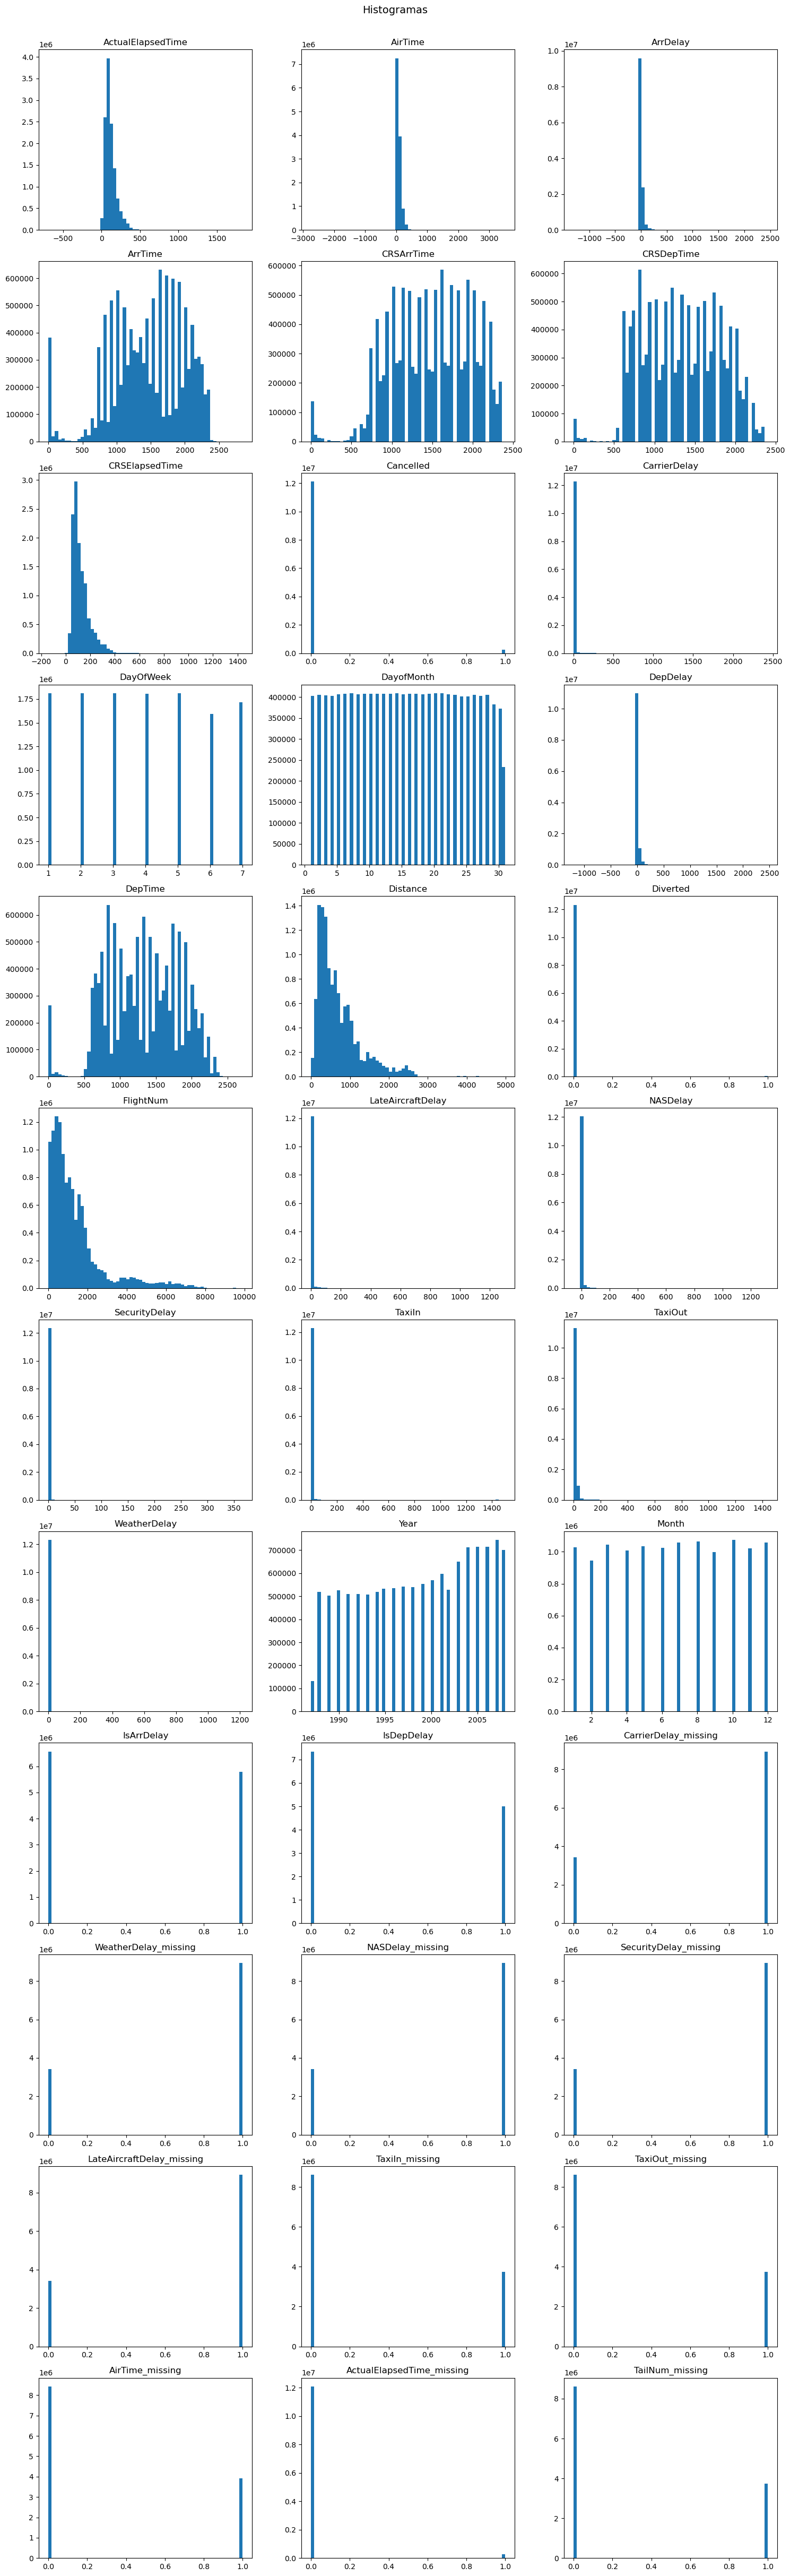

In [47]:
def spark_histogram(df, colname, bins=50):
    """
    Retorna (edges, counts) do histograma de `colname`,
    ignorando null/NaN.
    """
    rdd = (df.select(colname)
             .where(col(colname).isNotNull())
             .rdd.flatMap(lambda x: x))
    edges, counts = rdd.histogram(bins)   # computado em cluster
    return np.array(edges), np.array(counts)


nrow = int(np.ceil(len(numeric_cols)/3))
plt.figure(figsize=(15, 4*nrow))

for i, c in enumerate(numeric_cols, 1):
    edges, cnt = spark_histogram(sample_carrier, c, bins=60)
    plt.subplot(nrow, 3, i)
    plt.bar(edges[:-1], cnt, width=np.diff(edges), align="edge")
    plt.title(c)
    plt.tight_layout()

plt.suptitle("Histogramas", y=1.01, fontsize=14)
plt.show()


#### Distribuições Numéricas — Principais Conclusões

#### 1. Delays (`ArrDelay`, `DepDelay`, causas de atraso)

* Distribuição **altamente assimétrica** – grande pico em **0 min** e longa cauda positiva.
* Valores negativos (adiantamentos) são raros e de pequena magnitude.
* Colunas de causas (`CarrierDelay`, `WeatherDelay`, *etc.*) são **quase sempre 0**; barras esparsas > 0 indicam registro apenas quando o atraso foi atribuído oficialmente.

#### 2. Tempo de voo & Distância

* `AirTime`, `ActualElapsedTime`, `CRSElapsedTime`: formato “campânula truncada” com mediana **≈ 100 – 120 min**; cauda atinge **≈ 500 min** (rotas longas).
* `Distance` exibe **dois picos**:
  • < 500 mi (rotas curtas) • 1500 – 2500 mi (costas opostas dos EUA).

#### 3. Horários brutos (`DepTime`, `ArrTime`, CRS…)

* Barras verticais em cada centena (0600, 0700…) decorrem do formato **hhmm**.
* “Buracos” na madrugada confirmam menor operação noturna.

#### 4. Variáveis de calendário

* `DayOfWeek`, `DayofMonth`, `Month` **uniformes** → amostra bem representativa.
* `Year` cresce até 2007; queda visível em **2001 (11‑set)** e **2008 (crise)**.

#### 5. Taxi In / Taxi Out

* Pico forte perto de **0 min**; cauda mais curta que nos delays.
* Distribuição **discreta** (passos de 1 min) → considerar `log1p` ou “bucketização” para modelos lineares.

#### 6. Flags `_missing`

* Majoritariamente **0**; barras de **1** indicam 15 – 30 % de nulos na coluna original.
* Manter como **features binárias** ajuda o modelo a capturar padrões de ausência.

#### 7. Variáveis binárias (`Cancelled`, `Diverted`, `IsArrDelay`, `IsDepDelay`)

* **Fortemente desbalanceadas** (quase todos 0).
* Para modelos de classificação, aplicar **class weights** ou **(sobre)amostragem** das classes minoritárias.


## Treinamento

In [27]:
FLAG_MISS = ["AirTime","DepDelay","TaxiIn","TaxiOut","TailNum"]
CAT_LOW   = ["CancellationCode","UniqueCarrier"]      # OHE
HASH_IN   = ["TailNum","Route","Origin","Dest"]       # hash‑trick
NUM_COLS  = ["DepDelay","Distance","TaxiOut","TaxiIn",
             "AirTime","Month","DayOfWeek"]

# flags de ausência 
for c in FLAG_MISS:
    base = base.withColumn(f"{c}_missing",
                            functions.when(functions.col(c).isNull(), 1).otherwise(0))

# label + peso de classe 
df_lab = base.withColumn("label",
                         functions.when(functions.col("ArrDelay") > 15, 1).otherwise(0))

cnt = dict(df_lab.groupBy("label").count()
                     .rdd.map(lambda r: (int(r["label"]), r["count"]))  # {0: n0, 1: n1}
                     .collect())

target_ratio = 1.0                      # queremos ~1:1
frac0 = min((cnt[1] * target_ratio) / cnt[0], 1.0)
fractions = {0: frac0, 1: 1.0}

print(f"▼  Mantendo {frac0:.2%} da classe 0 (pontuais) — balanceamento.")

df_bal = df_lab.sampleBy("label", fractions, seed=42)

# ------------------------------------------------------------------#
# 3.  Peso de classe opcional (leve)                                #
# ------------------------------------------------------------------#
imb = df_bal.filter("label = 0").count() / df_bal.filter("label = 1").count()
df_w = df_bal.withColumn("class_weight",
                         functions.when(functions.col("label") == 1, functions.lit(imb)).otherwise(functions.lit(1.0)))

# ------------------------------------------------------------------#
# 4.  Capping 1‑99 % (sem duplicar col.)                            #
# ------------------------------------------------------------------#
num_cols = [f.name for f in df_w.schema if isinstance(f.dataType, NumericType)]
bounds   = {c: df_w.approxQuantile(c, [.01, .99], .001) for c in num_cols}

cap_exprs = []
for c in df_w.columns:
    if c in bounds:
        lo, hi = bounds[c]
        cap_exprs.append(
            f"CASE WHEN {c} < {lo} THEN {lo} "
            f"     WHEN {c} > {hi} THEN {hi} "
            f"     ELSE {c} END AS {c}")
    else:
        cap_exprs.append(c)

cap_sql  = "SELECT " + ",\n       ".join(cap_exprs) + " FROM __THIS__"
capper   = SQLTransformer(statement=cap_sql)

# ------------------------------------------------------------------#
# 5.  Imputer (mediana) para quaisquer NaNs restantes               #
# ------------------------------------------------------------------#
imputer = Imputer(inputCols=num_cols, outputCols=num_cols, strategy="median")

# ------------------------------------------------------------------#
# 6.  Engenharia de features compacta                               #
# ------------------------------------------------------------------#
CAT_LOW  = ["CancellationCode", "UniqueCarrier"]        # OHE
HASH_IN  = ["TailNum", "Route", "Origin", "Dest"]       # hash‑trick
NUM_COLS = ["DepDelay", "Distance", "TaxiOut", "TaxiIn",
            "AirTime", "Month", "DayOfWeek"]

stages = []
# OHE das low‑card
for c in CAT_LOW:
    stages += [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep"),
               OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_ohe", dropLast=False)]

# Hash‑trick em alta + mid (32 buckets p/ poupar RAM)
stages += [FeatureHasher(inputCols=HASH_IN,
                         outputCol="hash_vec",
                         numFeatures=32)]

assembler = VectorAssembler(
        inputCols=[f"{c}_ohe" for c in CAT_LOW] +
                  ["hash_vec"] +
                  NUM_COLS +
                  [f"{c}_missing" for c in FLAG_MISS],
        outputCol="features_raw",
        handleInvalid="keep")
stages.append(assembler)

fe_pipe = Pipeline(stages=stages)

# ------------------------------------------------------------------#
# 7.  GBT configurado para baixo consumo                             #
# ------------------------------------------------------------------#
gbt = GBTClassifier(
        featuresCol="features_raw",
        labelCol="label",
        weightCol="class_weight",
        maxDepth=4,
        maxBins=16,
        maxIter=30,
        subsamplingRate=0.7,
        featureSubsetStrategy="sqrt",
        cacheNodeIds=False,
        maxMemoryInMB=256,
        seed=42)

# ------------------------------------------------------------------#
# 8.  Pipeline final e treino                                       #
# ------------------------------------------------------------------#
full_pipeline = Pipeline(stages=[capper, imputer] + fe_pipe.getStages() + [gbt])

train, test = df_w.randomSplit([0.8, 0.2], seed=42)
train = train.persist(StorageLevel.MEMORY_AND_DISK)

model = full_pipeline.fit(train)
pred  = model.transform(test)

# ------------------------------------------------------------------#
# 9.  Métricas                                                      #
# ------------------------------------------------------------------#
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
auc = evaluator.evaluate(pred)
print(f"AUC ROC = {auc:.3f}")

# matriz de confusão simples
cm = (pred.groupBy("label", "prediction").count()
           .groupBy("label")
           .pivot("prediction", [0.0, 1.0])
           .sum("count")
           .fillna(0)
           .orderBy("label"))
cm.show()

▼  Mantendo 23.35% da classe 0 (pontuais) — balanceamento.
AUC ROC = 0.930
+-----+------+------+
|label|   0.0|   1.0|
+-----+------+------+
|  0.0|423652| 44134|
|  1.0| 84860|383017|
+-----+------+------+



### Avaliando o modelo

In [28]:
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
auc = evaluator.evaluate(pred)
print(f"AUC = {auc:.4f}")

conf = (pred
        .groupBy("label")                       # linhas = rótulo real
        .pivot("prediction", [0.0, 1.0])        # colunas = predição
        .count()
        .na.fill(0)
        .orderBy("label"))

AUC = 0.9303


In [29]:
# extrai valores
tn = conf.filter("label = 0").first()["0.0"]
fp = conf.filter("label = 0").first()["1.0"]
fn = conf.filter("label = 1").first()["0.0"]
tp = conf.filter("label = 1").first()["1.0"]

precision = tp/(tp+fp) if tp+fp else 0
recall    = tp/(tp+fn) if tp+fn else 0
f1        = 2*precision*recall/(precision+recall) if precision+recall else 0
print(f"Precisão = {precision:.3f} | Recall = {recall:.3f} | F1 = {f1:.3f}")

Precisão = 0.897 | Recall = 0.819 | F1 = 0.856


Text(0, 0, '423,652')

Text(1, 0, '44,134')

Text(0, 1, '84,860')

Text(1, 1, '383,017')

/tmp/ipykernel_133210/1807716337.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'Prevê 0', 'Prevê 1'])


[Text(-1.0, 1, ''),
 Text(0.0, 1, 'Prevê 0'),
 Text(1.0, 1, 'Prevê 1'),
 Text(2.0, 1, '')]

/tmp/ipykernel_133210/1807716337.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'Real 0',  'Real 1'])


[Text(0, -1.0, ''),
 Text(0, 0.0, 'Real 0'),
 Text(0, 1.0, 'Real 1'),
 Text(0, 2.0, '')]

Text(0.5, 1.0, 'Matriz de Confusão')

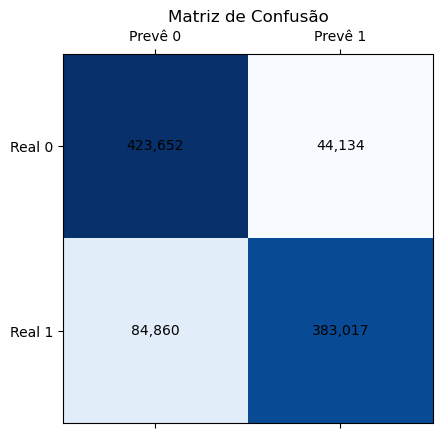

In [30]:
mat = np.array([[tn, fp],
                [fn, tp]])

fig, ax = plt.subplots()
cax = ax.matshow(mat, cmap="Blues")

for (i, j), v in np.ndenumerate(mat):
    ax.text(j, i, f"{int(v):,}", va='center', ha='center')

ax.set_xticklabels(['', 'Prevê 0', 'Prevê 1'])
ax.set_yticklabels(['', 'Real 0',  'Real 1'])
plt.title("Matriz de Confusão"); plt.show()

AUC ROC = 0.930  |  AUC PR = 0.934


<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 0, 'False‑Positive Rate')

Text(0, 0.5, 'True‑Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

<Axes: >

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Precision–Recall Curve')

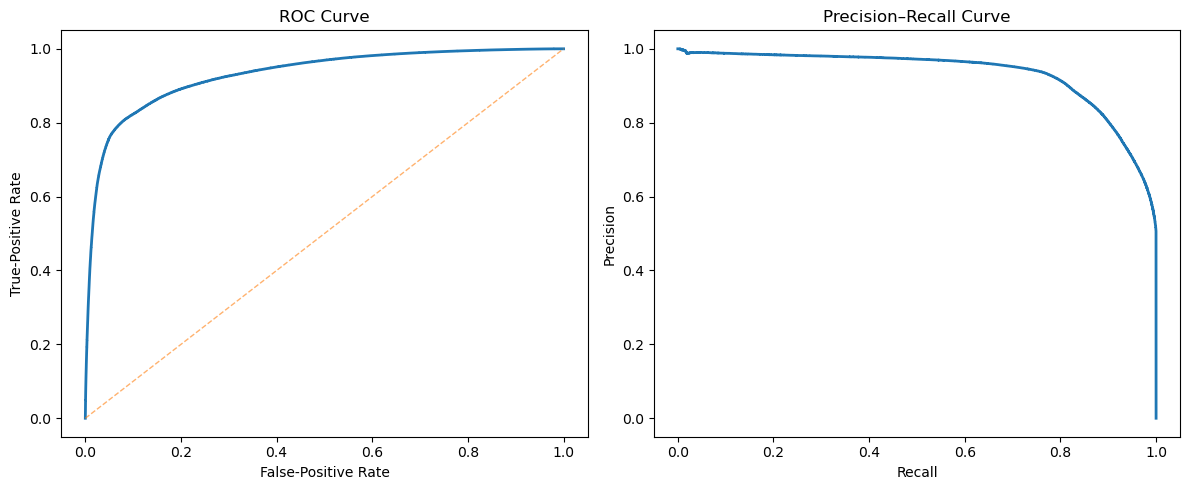

In [39]:
score_df = (pred
            .select(vector_to_array("probability")[1].alias("score"),  # p̂(y=1)
                    col("label").cast("int")))

# totPos / totNeg  (para normalizar FPR/TPR depois)
totPos = score_df.filter("label = 1").count()
totNeg = score_df.filter("label = 0").count()

# ------------------------------------------------------------------
# Ordena por score desc - acumula TP / FP  - calcula métricas
# ------------------------------------------------------------------
w = Window.orderBy(desc("score")).rowsBetween(Window.unboundedPreceding, 0)

roc_df = (score_df
          .withColumn("tp", ps_sum( (col("label") == 1).cast("int") ).over(w))
          .withColumn("fp", ps_sum( (col("label") == 0).cast("int") ).over(w))
          .withColumn("tpr", col("tp") / lit(totPos))          # recall
          .withColumn("fpr", col("fp") / lit(totNeg))
          .withColumn("prec", col("tp") / (col("tp") + col("fp")))
          .select("fpr", "tpr", "prec")              # já em ordem de corte
          .cache())

# –– pontos ROC
fpr = [0.0] + [r.fpr  for r in roc_df.select("fpr").collect()] + [1.0]
tpr = [0.0] + [r.tpr  for r in roc_df.select("tpr").collect()] + [1.0]

# –– pontos PR
rec = [0.0] + [r.tpr  for r in roc_df.select("tpr").collect()] + [1.0]  # recall = tpr
prec= [1.0] + [r.prec for r in roc_df.select("prec").collect()] + [0.0]  # completa bordas

# ------------------------------------------------------------------
# Área sob as curvas 
# ------------------------------------------------------------------
auc_roc = np.trapz(tpr, fpr)
auc_pr  = np.trapz(prec, rec)

print(f"AUC ROC = {auc_roc:.3f}  |  AUC PR = {auc_pr:.3f}")

# ------------------------------------------------------------------
# Plot
# ------------------------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],"--",lw=1, alpha=.6)
plt.xlabel("False‑Positive Rate"); plt.ylabel("True‑Positive Rate")
plt.title("ROC Curve")

plt.subplot(1,2,2)
plt.plot(rec, prec, lw=2)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve")

plt.tight_layout(); plt.show()

#### Conclusão


### 📈 O que os gráficos dizem sobre o modelo de previsão de atrasos

| Métrica                              | Observação                                                                                            | Interpretação prática                                                                                                                                                  |
| ------------------------------------ | ----------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **ROC**                              | Curva muito acima da diagonal → AUC ≈ 0 .93                                                           | O modelo separa bem voos pontuais (0) e atrasados (1); a cada 100 pares voo‑positivo/voo‑negativo escolhidos ao acaso, \~93 vezes o positivo terá score maior.         |
| **Início da ROC**                    | Subida quase vertical até FPR ≈ 5 % com TPR > 75 %                                                    | Podemos encontrar limiares que recuperam **¾ dos atrasos** sacrificando só 1 em cada 20 voos pontuais — bom para alertas operacionais.                                 |
| **Precision‑Recall**                 | Região plana perto de **Precisão > 0.9** até Recall ≈ 0.75                                            | Enquanto recuperamos até 75 % dos atrasos, +90 % das predições “vai atrasar” estão corretas ⇒ baixa taxa de “falsos alarmes”.                                          |
| **Queda abrupta após Recall > 0.85** | Para capturar os últimos 15 % de atrasos é preciso aceitar muita imprecisão (precisão cai para < 0.7) | Se a companhia quer **detectar quase todos** os atrasos, precisará lidar com um volume grande de alertas falsos; ajuste de threshold deve balancear custo × benefício. |

#### Resumo

* O classificador apresenta **excelente capacidade discriminante** (AUC 0.93).
* Há **faixa de limiares com ótima relação Recall ≈ 0.8 e Precision ≈ 0.9** — ideal para casos em que o atraso gera alto custo e um falso positivo é relativamente barato (ex.: replanejar gate, avisar passageiros).
* Além desse ponto, o ganho marginal em detectar atrasos adicionais vem acompanhado de queda acentuada na precisão; vale avaliar custo operacional antes de empurrar o threshold para baixo.

> **Próximos passos**
>
> * Definir threshold de decisão alinhado ao SLA/custo da companhia.
> * Analisar **feature importances** do GBT para entender drivers de atraso.
> * Testar re‑treino mensal para capturar sazonalidade e mudanças de operação.


### Modelos de Regressão

In [46]:
TARGET     = "ArrDelay"           
THRESHOLD  = 15                     

# PIPELINES por modelo
# LinearRegression
lin_reg = LinearRegression(
            featuresCol="features_raw",
            labelCol=TARGET,
            predictionCol="prediction",
            elasticNetParam=0.5,  
            maxIter=20,
            regParam=0.1)

# GBTRegressor
gbt_reg = GBTRegressor(
            featuresCol="features_raw",
            labelCol=TARGET,
            predictionCol="prediction",
            maxDepth=5,
            maxIter=60,
            maxBins=32,
            stepSize=0.05,
            seed=42)

pipe_lin = Pipeline(stages=[capper, imputer] + fe_pipe.getStages() + [lin_reg])
pipe_gbt = Pipeline(stages=[capper, imputer] + fe_pipe.getStages() + [gbt_reg])


# TREINO / TESTE 
train, test = df_w.randomSplit([0.8, 0.2], seed=42)

model_lin = pipe_lin.fit(train)
model_gbt = pipe_gbt.fit(train)

pred_lin  = model_lin.transform(test)
pred_gbt  = model_gbt.transform(test)

In [50]:
reg_eval = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction")

def reg_metrics(df, nome):
    rmse = reg_evaluator.evaluate(df, {reg_evaluator.metricName: "rmse"})
    mae  = reg_evaluator.evaluate(df, {reg_evaluator.metricName: "mae"})
    r2   = reg_evaluator.evaluate(df, {reg_evaluator.metricName: "r2"})
    print(f"\n▸ {nome}")
    print(f"   RMSE = {rmse:,.2f}  |  MAE = {mae:,.2f}  |  R² = {r2:.3f}")

reg_metrics(pred_lin, "Linear Regression")
reg_metrics(pred_gbt, "GBT Regressor")



▸ Linear Regression
   RMSE = 13.34  |  MAE = 9.16  |  R² = 0.875

▸ GBT Regressor
   RMSE = 13.03  |  MAE = 8.93  |  R² = 0.881


### Conclusão
| Modelo                | RMSE ↓        | MAE ↓        | R² ↑      | Impressão geral                                                       |
| --------------------- | ------------- | ------------ | --------- | --------------------------------------------------------------------- |
| **Linear Regression** | **13.34 min** | 9.16 min     | 0.875     | Baseline linear, já captura ≈ 88 % da variância.                      |
| **GBT Regressor**     | **13.03 min** | **8.93 min** | **0.881** | Pequeno ganho (≈ ‑2 % RMSE / +0.6 p.p. R²) graças a não‑linearidades. |

* **Erro típico** – O RMSE de 13 min significa que, em média, a previsão de atraso desvia desse valor (raiz‑quadrática).
* **Erro absoluto** – O MAE mostra que metade dos desvios fica dentro de \~9 min.
* **R² \~ 0.88** – explicamos quase 9 décimos da variância de `ArrDelay`; performance alta para dados reais de aviação.

---

#### Vale a troca para o GBT?

* **Sim, mas o ganho é modesto**: ≈ 20 segundos de RMSE e < 0.25 min de MAE.
* **Custo**: árvores gradient‑boost exigem mais memória/CPU e tempo de treino.
* **Quando usar**: se a previsão de poucos minutos fizer diferença operacional (ex.: sequenciamento de portões) e o ambiente aguentar o modelo.

---

#### Próximos passos sugeridos

1. **Hiper‑tunning leve**  
   *Depth*, *minInstancesPerNode*, *learningRate*. Mesmo um grid 2×2×2 pode extrair 1–2 p.p. extras de R².

2. **Features de tempo**  
   *Hora do dia* (bucket de 30 min) ou *sin/cos* de ângulo horário capturam padrões circadianos.

3. **Interações simples** (caso fique com LR)  
   Produtos como `DepDelay * Distance` ajudam a linearização sem crescer demais o feature‑set.

4. **Calibração de incerteza**  
   Treinar um modelo de quantis (GBTQuantileRegressor no Spark 3.5) fornece intervalo de atraso, não só ponto.

5. **Testar XGBoost ou LightGBM**  
   Se puder usar MLlib‑external ou migrar para pandas/Spark‑pandas; costumam dar 5–10 % de melhoria em RMSE com tuning semelhante.

---

**Resumo**
*GBTR* é ligeiramente melhor que *Linear Regression*, mas ainda não quebra paradigma. Escolha depende do orçamento computacional vs. necessidade de cada minuto de precisão.
